# Load the libraries & data

In [ ]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import scipy
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from ipywidgets import interact
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.utils import resample as sk_resample
from datasets import load_dataset
from sklearn.metrics import 
import statsmodels.api as sm
import jax
import pickle
import jax.numpy as jnp
import multiprocessing
from unicodedata import normalize as normalize_unicode


In [3]:

try:
    with open("dataset.pickle", "rb") as f:
        print("Loading from disk")
        dataset = pickle.load(f)
        print("Done from disk")
except FileNotFoundError:
    dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Handmade_Products", trust_remote_code=True)
    with open("dataset.pickle", "wb") as f:
        pickle.dump(dataset, f)

data = pd.DataFrame(dataset["full"])[["text", "rating"]]
data["text"] = data["text"].apply(lambda s: normalize_unicode("NFKD", s))
train_x, test_x, train_y, test_y = train_test_split(data["text"], data["rating"], test_size=0.2)
num_classes = np.unique(train_y).size
num_train_obs = train_x.shape[0]
train_x

Loading from disk
Done from disk


489739                           Cute! & went on perfectly.
73341     I bought this for my little sister. She has a ...
384999                   Nice quality, design and function.
401956    A lot of hardships for the person I gave this ...
152357                                       bought as gift
                                ...                        
609038    Loved the quality of the item and the professi...
345165           Wouldn’t peel or stick. Very disappointed.
1341      It’s cute but beware it comes with no frame so...
130487    Arrived earlier than expected, looks as expect...
69740                           Well made and cute designs.
Name: text, Length: 531329, dtype: object

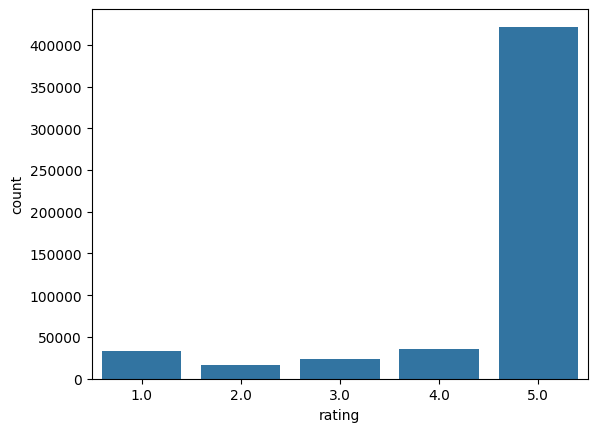

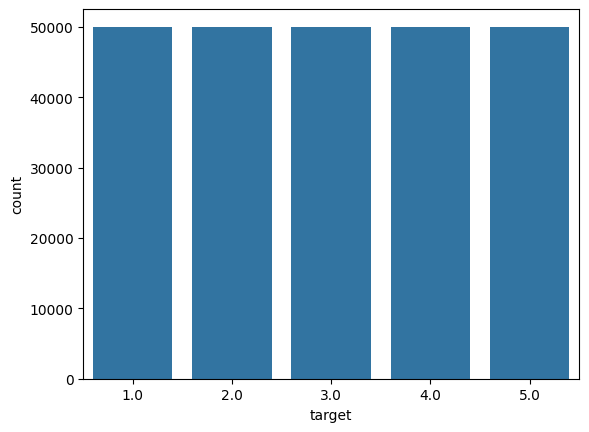

In [4]:
def visualize_class_imbalance(y):
    ch = sns.barplot(y.value_counts())
    return ch

def resample(x, y, target_samples):
    df = pd.concat([x, y], axis=1)
    df.columns = ['feature', 'target']


    resampled_dfs = []
    for category in df['target'].unique():
        category_df = df[df['target'] == category]
        n_samples = len(category_df)
        if n_samples < target_samples:
            # Upsample the minority class
            n_to_upsample = target_samples - n_samples
            upsampled = sk_resample(category_df,
                                     replace=True,
                                     n_samples=target_samples,
                                     random_state=42)
            resampled_dfs.append(upsampled)
        else:
            # If the class already has the maximum number of samples, keep it as is
            resampled_dfs.append(category_df.sample(target_samples))

    df_resampled = pd.concat(resampled_dfs)
    x_resampled = df_resampled['feature']
    y_resampled = df_resampled['target']
    return x_resampled, y_resampled
    
visualize_class_imbalance(train_y)
plt.show()
train_x_resampled, train_y_resampled = resample(train_x, train_y, 50000)
visualize_class_imbalance(train_y_resampled)
plt.show()

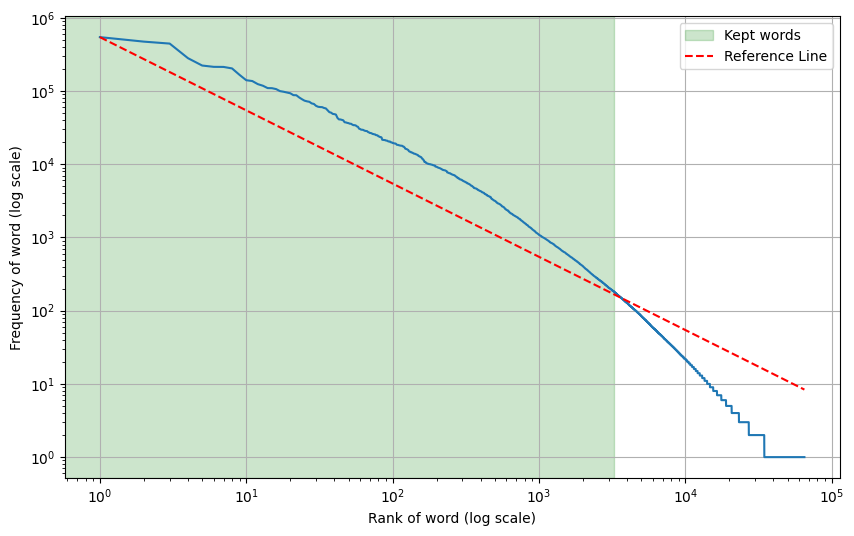

In [5]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_counts = vectorizer.fit_transform(train_x)

# Sum word counts across all documents
word_counts = np.asarray(X_train_counts.sum(axis=0)).flatten()

# Sort word counts in descending order
sorted_word_counts = np.sort(word_counts)[::-1]

# Create ranks (1, 2, 3, ...)
ranks = np.arange(1, len(sorted_word_counts) + 1)



# Create the log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_word_counts)
plt.xlabel("Rank of word (log scale)")
plt.ylabel("Frequency of word (log scale)")
plt.grid(True)


# Calculate a reference line based on Zipf's law (frequency ~ C/rank)
# We can set C = frequency of the most frequent word
zipf_line = sorted_word_counts[0] / ranks

plt.axvspan(0, len(ranks) * 0.05, ymin=0, ymax=1, color='green', alpha=0.2, label='Kept words')


# Plot the reference line
plt.loglog(ranks, zipf_line, label="Reference Line", linestyle='--', color='red')
plt.legend()
plt.savefig("figures/zipf_law.png")
plt.show()

In [6]:
word_counts = pd.DataFrame({"words": vectorizer.get_feature_names_out(), "counts": word_counts}) \
.sort_values("counts", ascending=False) \

quantiles = np.linspace(0, 1, 101)
indexes = quantiles * (len(word_counts) - 1)

word_percentiles = word_counts.iloc[indexes.astype(int), :].copy()
word_percentiles["percentile"] = (quantiles[::-1] * 100).astype(int)

word_percentiles = word_percentiles.rename(columns={"words": "word", "counts": "count"})

word_percentiles[:50].to_csv("figures/word_percentiles_top.csv", index=False)
word_percentiles[50:].to_csv("figures/word_percentiles_bottom.csv", index=False)
word_percentiles

,word,count,percentile
58099,the,544605,100
17516,dark,2103,99
6315,application,759,98
8138,balls,419,97
8092,balance,260,96
...,...,...,...
18479,deodorizing,1,4
16236,craftsmansh,1,3
42384,outpost,1,2
17303,dabu,1,1


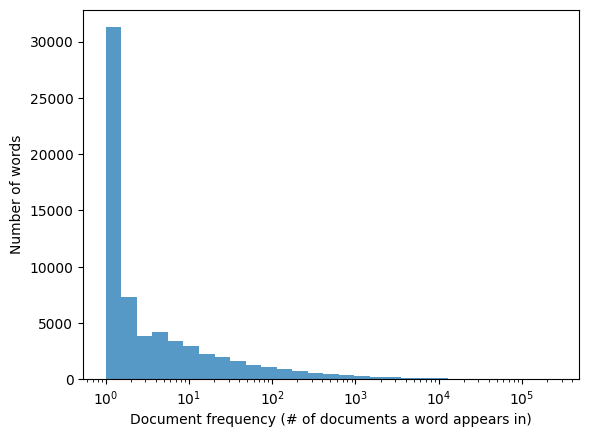

In [7]:

document_frequencies = np.asarray((X_train_counts > 0).sum(axis=0)).reshape((-1,))
axs = plt.axes()
ax = sns.histplot(document_frequencies, bins=np.logspace(np.log10(document_frequencies.min()), np.log10(document_frequencies.max()), 30))
ax.set_xscale("log")
ax.set_xlabel("Document frequency (# of documents a word appears in)")
ax.set_ylabel("Number of words")



plt.savefig("figures/document_frequency_histogram.png")

# Model

## Training

In [ ]:

class RemovePercentileWordsTransformer(TransformerMixin):
    def __init__(self, min_percentile, max_percentile):
        self.min_percentile = min_percentile
        self.max_percentile = max_percentile
        pass

    def fit(self, X, y=None, **fit_params):
        frequencies = np.asarray((X > 0).sum(axis=0)).reshape((-1,))
        
        max_occurances = int(np.percentile(frequencies, self.max_percentile*100.0))
        min_occurances = int(np.percentile(frequencies, self.min_percentile*100.0))
        self.keep_columns = np.logical_and(frequencies >= min_occurances, frequencies <= max_occurances)
        
        print(f"i.e. keeping {self.keep_columns.sum() / X.shape[1]} = {self.keep_columns.sum()} feature dimensions")
        return self

    def transform(self, X, y=None, **fit_params):
        cut_X = X[:, self.keep_columns]
        return cut_X


def get_vocabulary(X,min_percentile=0.95):
    cv = CountVectorizer().fit(X)
    word_counts = cv.transform(X).sum(axis=0).A1
    sorted_words = cv.get_feature_names_out()[np.argsort(word_counts)]
    return sorted_words[int(len(sorted_words) * min_percentile):]

def fit_lr_model(X, y, vocabulary):
    pipeline = Pipeline([
        ("tf", CountVectorizer(vocabulary=vocabulary)),
        ("classification", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ])
    pipeline.fit(X, y)
    return pipeline

def fit_lin_model(X, y, vocabulary):
    linear_pipeline = Pipeline([
        ("tf", CountVectorizer(vocabulary=vocabulary)),
        ("classification", LinearRegression(n_jobs=-1))
    ])
    linear_pipeline.fit(X, y)
    return linear_pipeline

def bootstrap_model(X: csr_matrix, y: np.ndarray, train_func, k=10):
    models = []
    for i in range(k):
        sample_indices = sk_resample(np.arange(X.shape[0]), replace=True)
        
        this_X = X.iloc[sample_indices]
        this_y = y.iloc[sample_indices]

        model = train_func(this_X, this_y, get_vocabulary(this_X))
        models.append(model)
        print(f"Model {i} trained")
    return models

def get_confidence_intervals(pipelines, alpha=0.05):
    intercepts = []
    coefs = []
    for pipeline in pipelines:
        intercepts.append(pipeline["classification"].intercept_)
        coefs.append(pipeline["classification"].coef_)

    # Calculate means and confidence intervals using the percentile method
    intercepts = np.array(intercepts)
    coefs = np.array(coefs)

    intercept_means = np.mean(intercepts, axis=0)
    intercept_ci_min = np.percentile(intercepts, alpha/2, axis=0)
    intercept_ci_max = np.percentile(intercepts, 1-alpha/2, axis=0)

    coeff_means = np.mean(coefs, axis=0)
    coeff_ci_min = np.percentile(coefs, alpha/2, axis=0)
    coeff_ci_max = np.percentile(coefs, 1-alpha/2, axis=0)
    
    return {
        "intercept_means": intercept_means,
        "intercept_ci_max": intercept_ci_max,
        "intercept_ci_min": intercept_ci_min,
        "coeff_means": coeff_means,
        "coeff_ci_max": coeff_ci_max,
        "coeff_ci_min": coeff_ci_min
    }

In [62]:
if os.path.exists("lin_pipelines.pickle"):
    print("Loading from disk")
    lin_pipelines = pickle.load(open("lin_pipelines.pickle", "rb"))
    print("Done from disk")
else:
    print("Training new models")
    lin_pipelines = bootstrap_model(train_x_resampled, train_y_resampled, fit_lin_model, k=10)
    pickle.dump(lin_pipelines, open("lin_pipelines.pickle", "wb"))


Training new models
Model 0 trained
Model 1 trained
Model 2 trained
Model 3 trained
Model 4 trained
Model 5 trained
Model 6 trained
Model 7 trained
Model 8 trained
Model 9 trained


In [63]:
if os.path.exists("lr_pipelines.pickle"):
    print("Loading from disk")
    lr_pipelines = pickle.load(open("lr_pipelines.pickle", "rb"))
    print("Done from disk")
else:
    print("Training new models")
    lr_pipelines = bootstrap_model(train_x_resampled, train_y_resampled, fit_lr_model, k=10)
    pickle.dump(lr_pipelines, open("lr_pipelines.pickle", "wb"))

Training new models
Model 0 trained
Model 1 trained
Model 2 trained
Model 3 trained
Model 4 trained
Model 5 trained
Model 6 trained
Model 7 trained
Model 8 trained
Model 9 trained


In [107]:
def get_significant_word_mask(pipelines, alpha=0.05):
    ci = get_confidence_intervals(pipelines, alpha=alpha)
    coeff_means = ci["coeff_means"]
    coeff_ci_max = ci["coeff_ci_max"]
    coeff_ci_min = ci["coeff_ci_min"]

    return ~np.logical_and(coeff_ci_min < 0, coeff_ci_max > 0)

In [127]:
lin_significant_word_mask = get_significant_word_mask(lin_pipelines, alpha=0.05)
lin_confidence_intervals = get_confidence_intervals(lin_pipelines, alpha=0.05)
lin_significant_words = pd.DataFrame({
    "word": get_vocabulary(train_x_resampled),
    "coeff_ci_min": lin_confidence_intervals["coeff_ci_min"],
    "coeff_means": lin_confidence_intervals["coeff_means"],
    "coeff_ci_max": lin_confidence_intervals["coeff_ci_max"],
    "is_significant": lin_significant_word_mask
})

lr_significant_word_mask = get_significant_word_mask(lr_pipelines, alpha=0.05)
lr_confidence_intervals = get_confidence_intervals(lr_pipelines, alpha=0.05)
def class_cis_to_df(class_cis):
    return pd.DataFrame({f"class_{i}": class_cis[i] for i in range(class_cis.shape[0])})


words = get_vocabulary(train_x_resampled)
classes = [f"class_{i+1}" for i in range(lr_confidence_intervals["coeff_ci_min"].shape[0])]
multi_index = pd.MultiIndex.from_product([classes, words], names=["class", "word"])

lr_significant_words = pd.DataFrame({
    "coeff_ci_min": lr_confidence_intervals["coeff_ci_min"].flatten(),
    "coeff_means": lr_confidence_intervals["coeff_means"].flatten(),
    "coeff_ci_max": lr_confidence_intervals["coeff_ci_max"].flatten(),
    "is_significant": lr_significant_word_mask.flatten()
}, index=multi_index).reset_index()
lr_significant_words

,class,word,coeff_ci_min,coeff_means,coeff_ci_max,is_significant
0,class_1,citrine,0.034510,0.305332,0.590202,True
1,class_1,48,-1.017973,-0.699998,-0.402447,True
2,class_1,lays,-0.004500,0.109647,0.260246,False
3,class_1,industrial,-1.352111,-0.918012,-0.511437,True
4,class_1,tore,0.177519,0.303928,0.410291,True
...,...,...,...,...,...,...
16280,class_5,for,-0.114452,-0.103944,-0.085558,True
16281,class_5,to,-0.150738,-0.131724,-0.117694,True
16282,class_5,and,0.086340,0.098579,0.107552,True
16283,class_5,it,-0.001366,0.010193,0.021393,False


In [132]:
lin_new_vocab = lin_significant_words[lin_significant_words["is_significant"]]["word"].unique()
lr_new_vocab = lr_significant_words[lr_significant_words["is_significant"]]["word"].unique()

In [135]:
lin_new_vocab.size / lr_pipelines[0].named_steps["tf"].get_feature_names_out().size, \
    lr_new_vocab.size / lr_pipelines[0].named_steps["tf"].get_feature_names_out().size

(0.6720908811789991, 0.9815781393920786)

In [137]:
new_lin_pipeline = fit_lin_model(train_x_resampled, train_y_resampled, lin_new_vocab)
new_lr_pipeline = fit_lr_model(train_x, train_y, lr_new_vocab)

In [138]:
def advanced_stats(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize="true")

    ConfusionMatrixDisplay(cm).plot()
    report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).drop(columns=["accuracy"])


    within_1_prop = np.array([
        (np.abs(y_true[y_true == i] - y_pred[y_true == i]) <= 1.001).mean() for i in range(1, num_classes+1)
    ])

    within_1_prop_tot = (np.abs(y_true - y_pred) <= 1.001).mean() 

    report.loc['within-1'] = np.array([*within_1_prop, within_1_prop.mean(), within_1_prop_tot])
    return report.rename(columns={"1.0": "one", "2.0": "two", "3.0": "three", "4.0": "four", "5.0": "five", "macro avg": "macroavg", "weighted avg": "weightedavg"}).round(3)

Model: lr


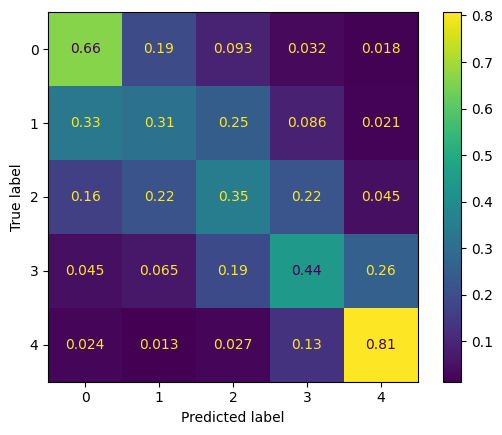

,one,two,three,four,five,macroavg,weightedavg
precision,0.509,0.206,0.251,0.208,0.967,0.428,0.830
recall,0.663,0.312,0.351,0.443,0.807,0.515,0.737
f1-score,0.576,0.248,0.293,0.283,0.880,0.456,0.774
support,8271.000,4082.000,6065.000,9165.000,105250.000,132833.000,132833.000
within-1,0.857,0.893,0.792,0.890,0.935,0.874,0.920


Model: new_lr


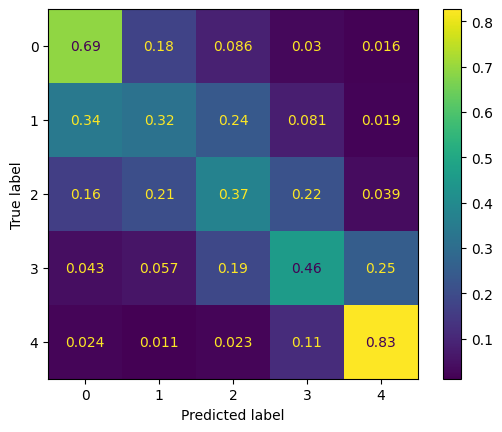

,one,two,three,four,five,macroavg,weightedavg
precision,0.518,0.226,0.279,0.232,0.969,0.445,0.836
recall,0.692,0.318,0.374,0.460,0.827,0.534,0.757
f1-score,0.592,0.264,0.320,0.309,0.892,0.476,0.788
support,8271.000,4082.000,6065.000,9165.000,105250.000,132833.000,132833.000
within-1,0.868,0.900,0.797,0.900,0.941,0.881,0.926


Model: lin


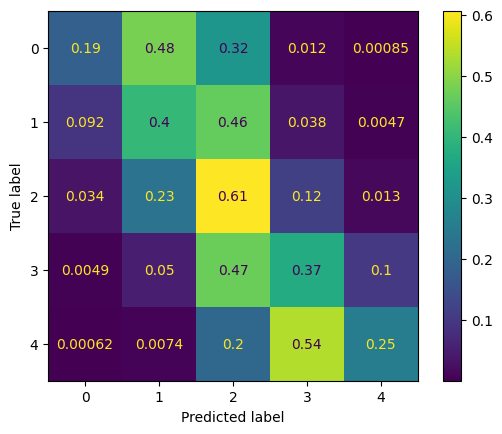

,one,two,three,four,five,macroavg,weightedavg
precision,0.692,0.199,0.109,0.056,0.963,0.404,0.821
recall,0.187,0.404,0.606,0.373,0.254,0.365,0.279
f1-score,0.295,0.267,0.184,0.098,0.402,0.249,0.360
support,8271.000,4082.000,6065.000,9165.000,105250.000,132833.000,132833.000
within-1,0.669,0.958,0.953,0.945,0.790,0.863,0.806


Model: new_lin


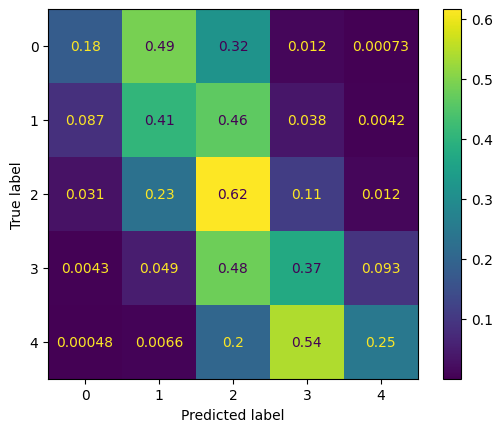

,one,two,three,four,five,macroavg,weightedavg
precision,0.703,0.201,0.110,0.056,0.965,0.407,0.823
recall,0.180,0.407,0.616,0.374,0.247,0.365,0.273
f1-score,0.287,0.269,0.186,0.097,0.393,0.246,0.352
support,8271.000,4082.000,6065.000,9165.000,105250.000,132833.000,132833.000
within-1,0.671,0.957,0.958,0.947,0.789,0.864,0.806


In [141]:
from IPython.display import display
for name, model in {
    "lr": lr_pipelines[0],
    "new_lr": new_lr_pipeline,
}.items():   
    print(f"Model: {name}")
    stats = advanced_stats(test_y, model.predict(test_x))
    stats.round(3).to_csv(f"figures/evaluation_{name}.csv", index_label="Quantity")
    plt.savefig(f"figures/confusion_matrix_{name}.png")
    plt.show()
    display(stats)
    
for name, model in {
    "lin": lin_pipelines[0],
    "new_lin": new_lin_pipeline
}.items():
    print(f"Model: {name}")
    stats = advanced_stats(test_y, model.predict(test_x).round().clip(1, 5))
    stats.round(3).to_csv(f"figures/evaluation_{name}.csv", index_label="Quantity")
    plt.savefig(f"figures/confusion_matrix_{name}.png")
    plt.show()
    display(stats)

## Parameter analysis

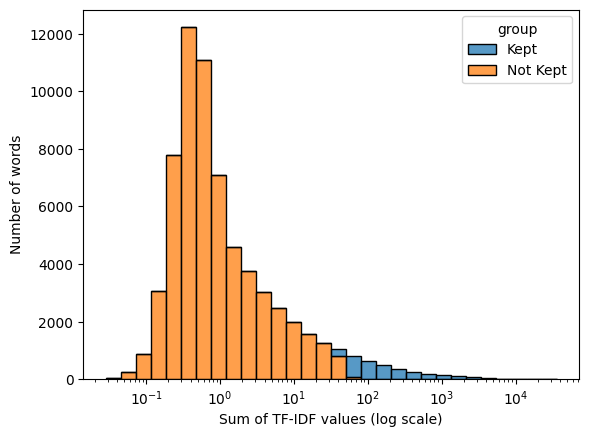

In [26]:
tfidf = TfidfVectorizer()
tfidf.fit(train_x)

tfidf_sums = pd.DataFrame({
    "words": tfidf.get_feature_names_out().reshape(-1),
    "values": tfidf.transform(train_x).sum(axis=0).A1
})
sums_kept = tfidf_sums[pipeline.named_steps["remove_percentile_words"].keep_columns].copy()
sums_not_kept = tfidf_sums[~pipeline.named_steps["remove_percentile_words"].keep_columns].copy()

# Add group labels
sums_kept['group'] = 'Kept'
sums_not_kept['group'] = 'Not Kept'

sns.histplot(data=pd.concat([sums_kept, sums_not_kept]), x="values", hue="group", multiple="stack", bins=30, log_scale=True)
plt.xlabel("Sum of TF-IDF values (log scale)")
plt.ylabel("Number of words")
plt.show()

In [14]:
lr: LogisticRegression = pipeline.named_steps["classification"]
tf: CountVectorizer = pipeline.named_steps["tf"]
remove_percentile_words: RemovePercentileWordsTransformer = pipeline.named_steps["remove_percentile_words"]

betas = np.hstack((lr.intercept_.reshape((-1, 1)), lr.coef_)) # (n_classes, p+1)

tf_matrix = remove_percentile_words.transform(tf.transform(train_x))
X_design = scipy.sparse.hstack([csr_matrix(np.ones((tf_matrix.shape[0], 1))), tf_matrix], format='csr')

In [15]:
scores = X_design @ betas.T
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [180]:
scores = pd.DataFrame(pipeline.named_steps["classification"].coef_.T).rename(columns={i: f"{i+1}" for i in range(5)})
scores["word"] = pipeline.named_steps["tf"].get_feature_names_out()
some_scores = scores[scores["word"].isin(["love", "best", "hate", "disappointed", "the", "slightly"])].sort_values("5").set_index("word")
some_scores.rename(columns={
    "1": "one", 
    "2": "two",
    "3": "three",
    "4": "four",
    "5": "five"
}).round(3).to_csv("figures/some_word_scores.csv")
some_scores

,1,2,3,4,5
word,,,,,
disappointed,1.144698,0.982330,0.446484,-0.805700,-1.767813
hate,0.773035,0.334019,0.288957,-0.274502,-1.121509
the,-0.046200,0.038662,0.060068,0.025634,-0.078164
slightly,-1.066083,-0.353240,0.070443,0.880478,0.468402
best,-0.666232,-0.259321,-0.128545,0.253276,0.800821
love,-1.391594,-0.724947,-0.137839,0.781668,1.472711


In [176]:

scores_by_class = scores.set_index('word').stack().reset_index().rename(columns={"level_1": "class", 0: "score"}).set_index(["word", "class"])


top_scores_by_class = scores_by_class.groupby("class").apply(lambda x: x.sort_values("score", key=lambda k: abs(k), ascending=False).head(5)).reset_index(2).drop(columns=["class"])
top_scores_by_class.to_csv("figures/top_scores_by_class.csv")
top_scores_by_class

score
class word                   
1     brings        -2.682182
      complements   -2.358831
      unhappy        2.041632
      excelente     -2.028548
      garbage        1.939216
2     memory        -2.439198
      charming      -2.185168
      steal         -2.177089
      served        -2.125523
      kick          -2.034151
3     whiskey       -2.264110
      church        -1.819968
      turkey        -1.810406
      disappoint    -1.736091
      unexpected    -1.728778
4     downside       1.749878
      appreciation  -1.720024
      infected      -1.637754
      garage        -1.508593
      served         1.462298
5     disappointing -2.746002
      excelente      2.656131
      happier        2.609821
      unhappy       -2.445116
      skeptical      2.335833

# Word correlations

In [ ]:
def get_cor(corpus, word1, word2):
    cv = CountVectorizer()
    tf = cv.fit_transform(corpus)
    word1idx = list(cv.get_feature_names_out()).index(word1)
    word2idx = list(cv.get_feature_names_out()).index(word2)

    counts = tf[:, [word1idx, word2idx]]
    cov = np.cov(counts.toarray(), rowvar=False)
    return cov[0, 1] / math.sqrt(cov[0, 0] * cov[1, 1])

get_cor(train_x, "recommend", "worst")
get_cor(train_x, "recommend", "best")

word_pairs = [
    ("recommend", "worst"),
    ("recommend", "best"),
    ("recommend", "love"),
    ("recommend", "hate"),
    ("recommend", "like"),
    ("recommend", "dislike"),
    ("recommend", "enjoy"),
    ("recommend", "disappoint"),
    ("recommend", "satisfied"),
    ("recommend", "unsatisfied")
]



np.float64(0.024703716166173152)

In [ ]:
def word_covariances(tf_mat: np.ndarray):
    n, d = tf_mat.shape
    print(tf_mat.shape)
    mean_freq = tf_mat.mean(axis=0).A1
    XtX = tf_mat.T @ tf_mat
    mean_outer = jnp.outer(mean_freq, mean_freq) * n

    # Using Cov(X) = (X'X - x_bar x_bar' * n)/(n-1)
    cov_uncorrected = jnp.subtract(XtX.toarray(), mean_outer).astype("float32")
    cov = jnp.divide(cov_uncorrected, n-1)
    return cov


try:
    word_cov = np.load("word_cov.npy")
    print("Loaded from disk")
except FileNotFoundError:
    print("Calculating")
    word_cov = word_covariances(pipeline.named_steps["tf"].transform(train_x))
    np.save("word_cov.npy", word_cov)
    print("Calculated")

word_var = jnp.diag(word_cov)

inv_std_dev = (word_var ** -0.5).astype("float32")
# Calculate correlation matrix using broadcasting to avoid large diagonal matrices
word_cor = jnp.dot(jnp.dot(inv_std_dev[:, None],  word_cov), inv_std_dev[None, :])

Calculating
(531329, 65304)


2025-05-02 19:55:29.114729: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 15.89GiB (rounded to 17058449664)requested by op 
2025-05-02 19:55:29.114792: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ****************************___________________________*****************************________________
E0502 19:55:29.114804 2479011 pjrt_stream_executor_client.cc:2839] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17058449664 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17058449664 bytes.

In [91]:
np.array(inv_std_dev[:, None].T) @ np.array(word_cov) @ np.array(inv_std_dev[:, None])

array([[276596.38]], dtype=float32)

In [92]:
word_cov.shape

(36409, 36409)

In [33]:
tf: CountVectorizer = pipeline.named_steps["tf"]
# Create inverse vocabulary mapping (index -> word)
inv_vocabulary = {v: k for k, v in tf.vocabulary_.items()}

# Get the indices from word_pairs
idx1 = word_pairs[0]
idx2 = word_pairs[1]

# Find the corresponding words
print("Top 10 word pairs by covariance:")
for i in range(len(idx1)):
    word1 = inv_vocabulary.get(int(idx1[i]), "N/A")
    word2 = inv_vocabulary.get(int(idx2[i]), "N/A")
    print(f"({word1}, {word2}) - Covariance: {values[i]:.4f}")



Top 10 word pairs by covariance:
(11x14, sending) - Covariance: 1.0000
(12, according) - Covariance: 1.0000
(12, decorating) - Covariance: 1.0000
(12, ribbon) - Covariance: 1.0000
(123, 4mm) - Covariance: 1.0000
(123, pounds) - Covariance: 1.0000
(123, studs) - Covariance: 1.0000
(13, 21) - Covariance: 1.0000
(13, attest) - Covariance: 1.0000
(13, caught) - Covariance: 1.0000
(13, cord) - Covariance: 1.0000
(13, db1f7f51a1c731870846e43261d55445) - Covariance: 1.0000
(13, depending) - Covariance: 1.0000
(13, elasticized) - Covariance: 1.0000
(13, fate) - Covariance: 1.0000
(13, gotta) - Covariance: 1.0000
(13, heavier) - Covariance: 1.0000
(13, lab) - Covariance: 1.0000
(13, labradorite) - Covariance: 1.0000
(13, rare) - Covariance: 1.0000
(13, ruin) - Covariance: 1.0000
(13, stretchy) - Covariance: 1.0000
(13, tempt) - Covariance: 1.0000
(13, tones) - Covariance: 1.0000
(13, tugged) - Covariance: 1.0000
(13, viewing) - Covariance: 1.0000
(13, visible) - Covariance: 1.0000
(16x20, dream

In [ ]:
def get_parameter_intervals(model: LinearRegression):
    model.coef_ # (n, d)

#np.nanmin(word_cov)
word_cov.shape
jnp.nanmin(word_cov)
jnp.nanmax(word_cov)


In [14]:
import pickle
with open("word_cov.pickle", "wb") as f:
    pickle.dump(np.array(word_cov), f)

In [ ]:

jnp.nanmin(word_cov)

Loading from disk
Loaded from disk


KeyboardInterrupt: 

In [19]:
cv = CountVectorizer()
word_counts = cv.fit_transform(train_x).sum(axis=0).reshape((-1, ))

In [20]:
percentile_words = np.array(np.argsort(word_counts)[:, np.linspace(word_counts.shape[1]/2, word_counts.shape[1]-1, 49).astype("int")]).reshape((-1, ))
print()
voc_inv = dict(zip(cv.vocabulary_.values(), cv.vocabulary_.keys()))
percentiles = np.linspace(51, 100, 49)
words = []
counts = []
for p in percentile_words:
    words.append(voc_inv[int(p)])
    counts.append(word_counts[0, p])
    
print(words)
word_percentiles = pd.DataFrame({'percentile': percentiles, 'word': words, "count": counts})
word_percentiles["percentile"] = np.round(word_percentiles["percentile"])
word_percentiles.to_csv("word_percentiles.csv", index=False)


['brink', 'pocketable', 'marlinspike', 'soundbar', 'silpada', 'topmost', 'atones', 'fanstastic', 'asg', '2month', 'sevice', 'wasp', 'dpt', 'costal', 'drs', 'angus', 'julius', 'knotty', 'lingered', 'mjlulu', 'matcha', 'ami', 'pleasurable', 'serotonin', 'salute', 'noone', 'cloak', 'mot', 'aparte', 'paranoid', '09', 'groovy', 'component', 'unsurpassed', 'jute', 'deter', 'tender', 'lounge', 'motto', 'grabbing', 'essence', 'continues', 'grandfather', 'serious', 'situation', 'garbage', 'pearls', 'arrive', 'the']


TimeoutError: [Errno 60] Operation timed out: 'word_percentiles.csv'

In [ ]:
def get_classification_report(pred_y, test_y):
    report = pd.DataFrame(classification_report(pred_y, test_y, output_dict=True))

    # Remove the accuracy column from the report since that formats badly
    return report.drop(columns=["accuracy"])

get_classification_report(pred_y, test_y)

,1.0,2.0,3.0,4.0,5.0,macro avg,weighted avg
precision,0.696322,0.253504,0.313518,0.411309,0.799249,0.494781,0.686977
recall,0.380488,0.189316,0.243194,0.218198,0.963315,0.398902,0.727696
f1-score,0.492087,0.216758,0.273914,0.285133,0.873646,0.428308,0.692799
support,15078.000000,5541.000000,7677.000000,17035.000000,87502.000000,132833.000000,132833.000000
